In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sc_signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

import torch

In [2]:
import sys 
sys.path.append("/home/aurelien.stumpf/Code")
from eeg_project_package import dataset, models, training, spectral_analysis

In [51]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(spectral_analysis)

<module 'eeg_project_package.spectral_analysis' from '/home/aurelien.stumpf/Code/eeg_project_package/spectral_analysis.py'>

Extracting EDF parameters from /network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 237999  =      0.000 ...   475.998 secs...


/tmp/ipykernel_241700/1123243477.py:6: RuntimeWarning: Invalid patient information 
  raws = read_raw_edf(input_fname1, preload=True)


Number of channels:  64
Number of samples:  64
Using matplotlib as 2D backend.


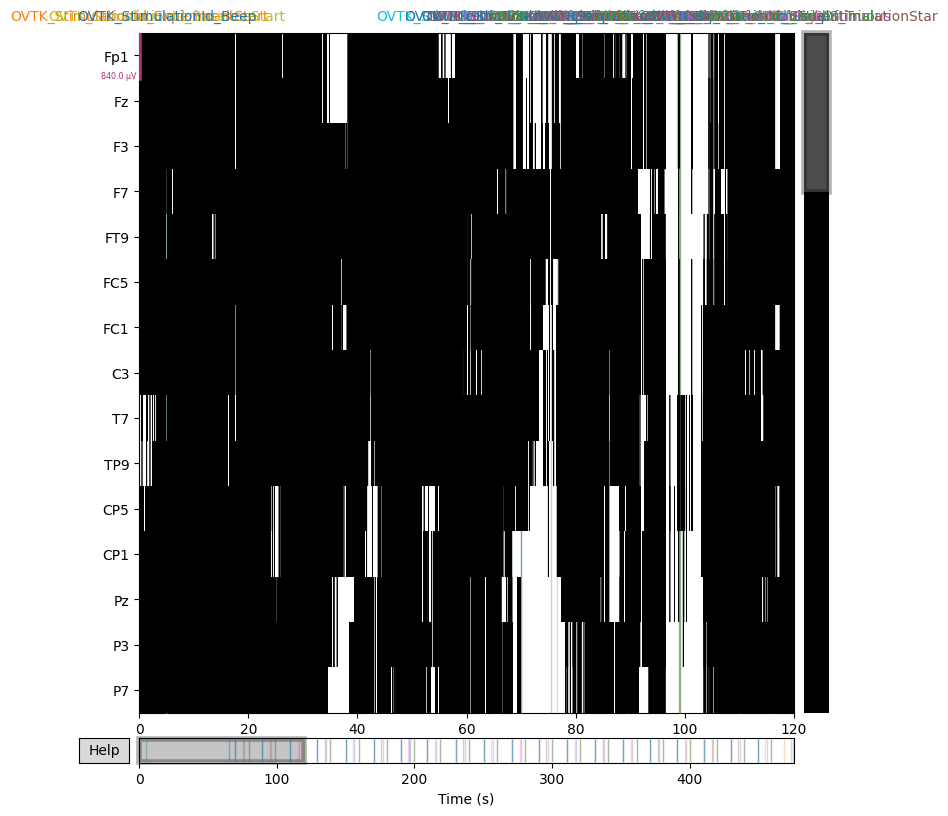

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


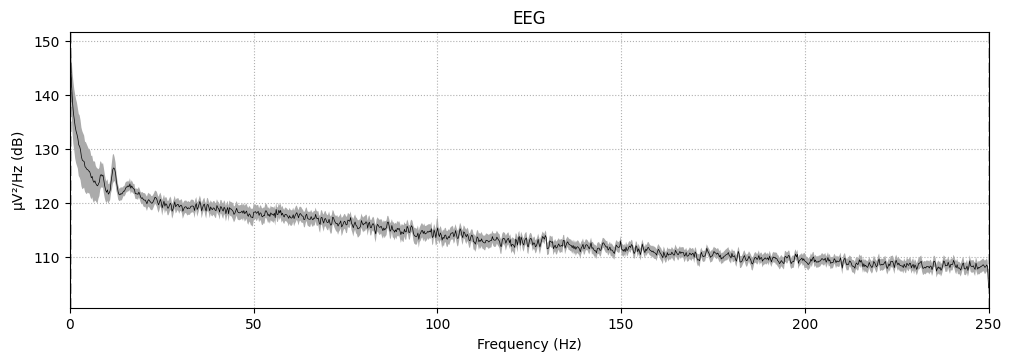

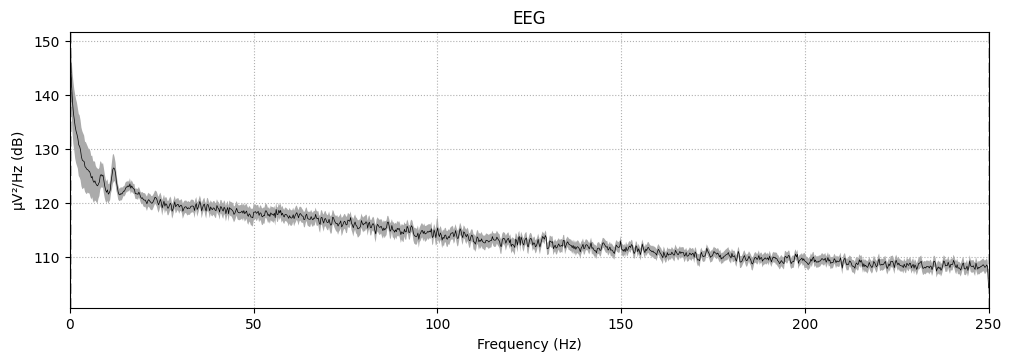

In [3]:
#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf"
input_fname2 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.09.24].edf"
input_fname3 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-16.30.16].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

In [117]:
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]
#list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/"

num_subjects = [14]
num_train_sessions = [1]
num_test_sessions = [2]
num_runs = []
list_labels = ['OVTK_GDF_Left','OVTK_GDF_Right']

numpy_trainset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_subjects, num_train_sessions, num_runs, list_idx_channels, list_labels, data="bci", type_="numpy")
numpy_testset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_subjects, num_test_sessions, num_runs, list_idx_channels, list_labels, data="bci", type_="numpy")

/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()


Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-02/EEG/Test-[2022.04.28-16.18.42].edf
[Errno 5] Input/output error: '/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-02/EEG/Test-[2022.04.28-16.18.42].edf'


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:8: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:154: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()


In [4]:
list_train_files = ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf'
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.09.24].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.18.26].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-15.36.18].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-15.46.20].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-15.55.59].edf']

list_test_files = [
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-16.19.27].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-16.30.16].edf']

list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_name_channels = ["CP3"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]
#list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/"


list_labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

numpy_trainset = dataset.EEG_PSD_Dataset_Multi_Subject(list_files = list_train_files, list_idx_channels = list_idx_channels, list_labels = list_labels, data="bci", type_="numpy")
numpy_testset = dataset.EEG_PSD_Dataset_Multi_Subject(list_files = list_test_files, list_idx_channels = list_idx_channels, list_labels = list_labels, data="bci", type_="numpy")


Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.09.24].edf
[Errno 20] Not a directory: '/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.09.24].edf'


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:11: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:157: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:11: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points ...
2 bad epochs dropped


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:157: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:11: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


KeyboardInterrupt: 

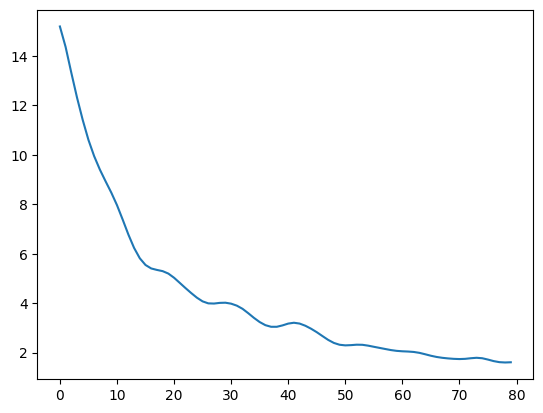

In [7]:
plt.plot(signal_rest[20:])
plt.show()

In [5]:
files = ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.09.24].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.18.26].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-15.36.18].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-15.46.20].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-15.55.59].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-16.19.27].edf',
'/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Test-[2022.05.05-16.30.16].edf']
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']
list_name_channels = ["CP1","CP3","CP5","C1","C3"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

for file in files :
    print(file)
    list_file = [file]
    signal, list_labels, list_freqs = dataset.psd_dataset_creator(list_file, list_idx_channels, labels, type_="numpy", type_psd = "burg")
    colors = ['r','b']
    # Plot the PSD with variance
    if signal.shape[0] == 0:
        continue
    else:
        label_rest = np.argwhere(list_labels == 0)
        print(signal.shape)
        signal = np.sum(signal, axis = 1)
        signal_rest = np.mean(signal[label_rest,:],axis = 0).reshape(-1)
        signal_rest_std_dev = np.std(signal[label_rest,:],axis = 0).reshape(-1)
        plt.plot(list_freqs[:20],signal_rest[:20], color='r')
        plt.fill_between(list_freqs[:20], signal_rest[:20]-signal_rest_std_dev[:20], signal_rest[:20]+signal_rest_std_dev[:20], color='r', alpha=0.2)

        label_mi = np.argwhere(list_labels == 1)
        signal_mi = np.mean(signal[label_mi,:],axis = 0).reshape(-1)
        signal_mi_std_dev = np.std(signal[label_mi,:],axis = 0).reshape(-1)
        plt.plot(list_freqs[:20],signal_mi[:20], color='b')
        plt.fill_between(list_freqs[:20], signal_mi[:20]-signal_mi_std_dev[:20], signal_mi[:20]+signal_mi_std_dev[:20], color='b', alpha=0.2)
        plt.show()



/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf


/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:11: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped
(10, 5, 2001)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200

/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:157: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:11: RuntimeWarning: Invalid patient information 
  raw_Training_EEG =  mne.io.read_raw_edf(filepath, preload=True, verbose=False)


Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_ExperimentStop', 'OVTK_StimulationId_Train', 'OVTK_StimulationId_VisualStimulationStar']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 86 events and 2001 original time points ...
2 bad epochs dropped
(10, 5, 2001)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200

/home/aurelien.stumpf/Code/eeg_project_package/dataset.py:157: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()


TypeError: 'NoneType' object is not subscriptable

In [53]:
X_train = numpy_trainset.features[:,:,:20].reshape(numpy_trainset.features.shape[0], -1)
y_train = numpy_trainset.labels
X_test = numpy_testset.features[:,:,:20].reshape(numpy_testset.features.shape[0], -1)
y_test = numpy_testset.labels

# Train LDA classifier
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA Accuracy: ", acc)

# Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM Accuracy: ", acc)

# Train XGBoost classifier
bst = XGBClassifier(n_estimators=10, max_depth=5, learning_rate=0.5, objective='binary:logistic')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
acc = np.mean(preds == y_test)
print("XGBoost Accuracy: ", acc)

LDA Accuracy:  0.9
SVM Accuracy:  0.9
XGBoost Accuracy:  0.925


1


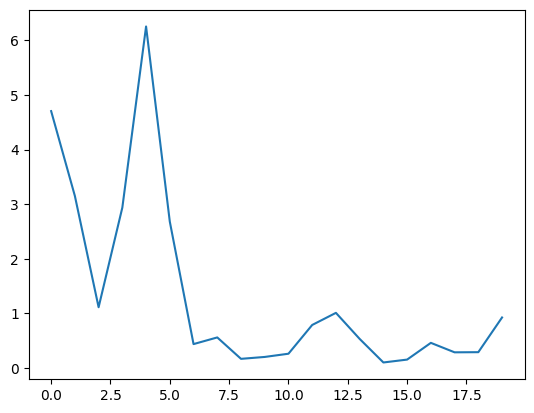

-----------------
0


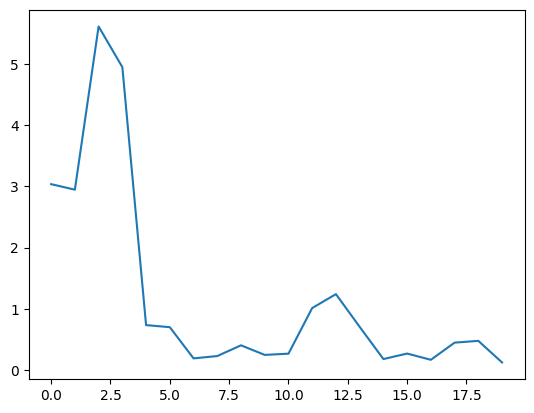

-----------------
0


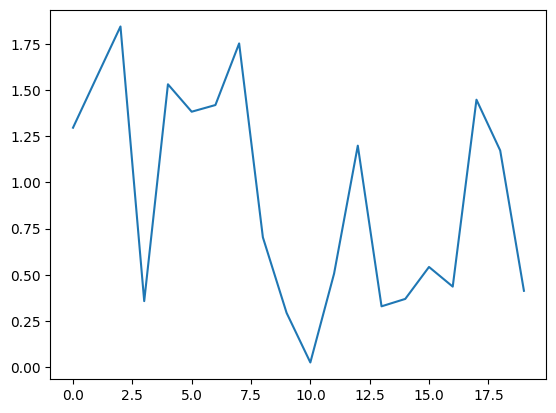

-----------------
1


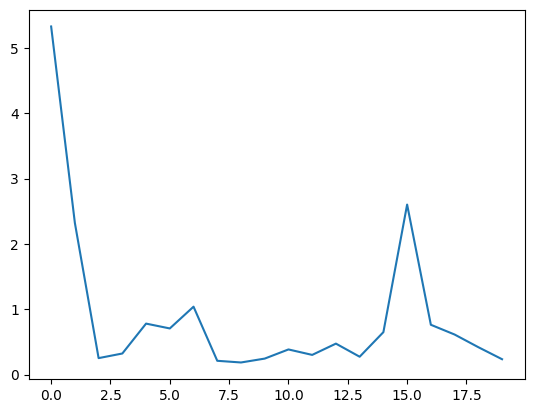

-----------------
1


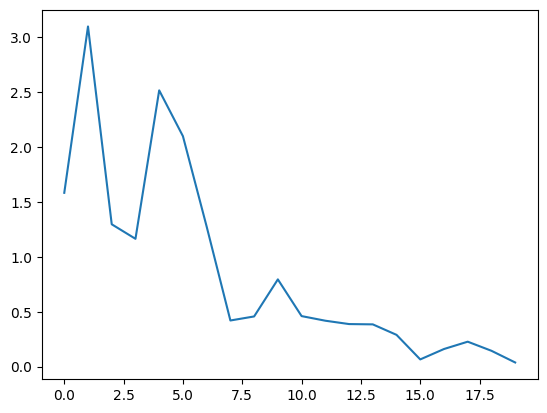

-----------------
0


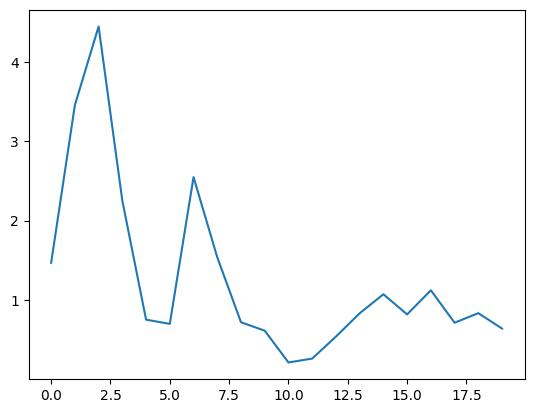

-----------------
0


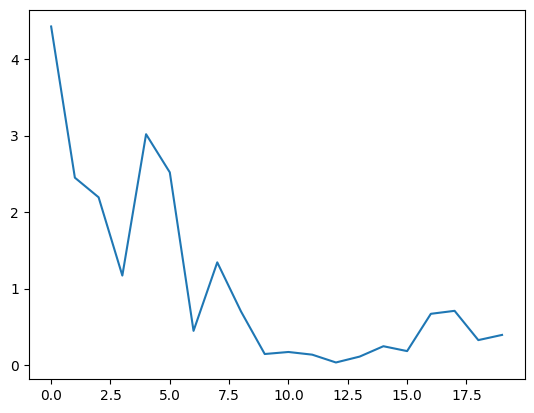

-----------------
1


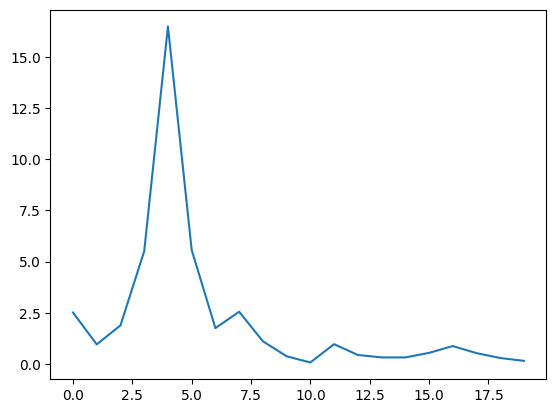

-----------------
1


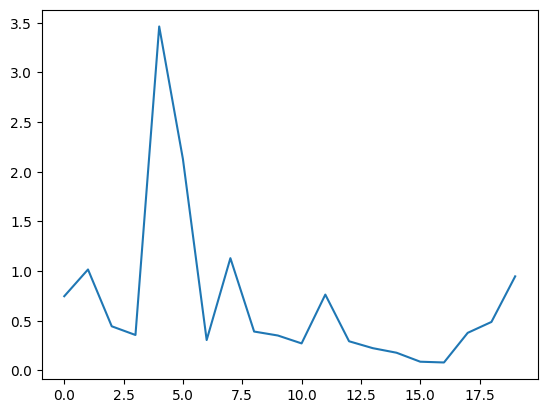

-----------------
0


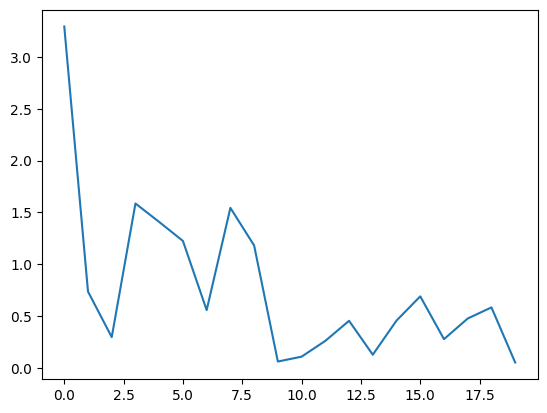

-----------------
1


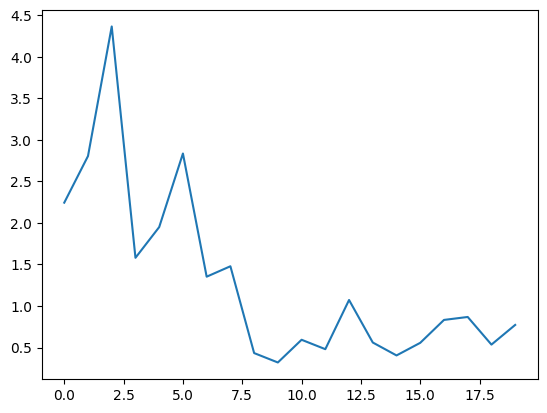

-----------------
0


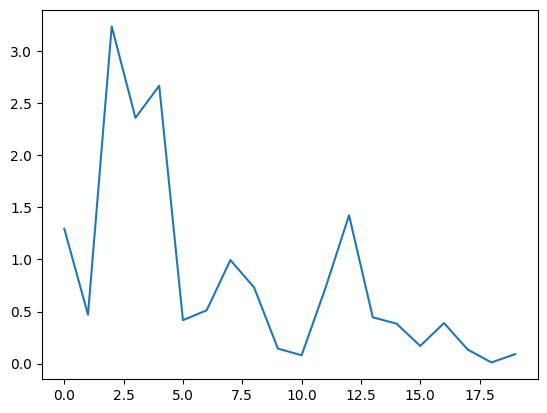

-----------------
1


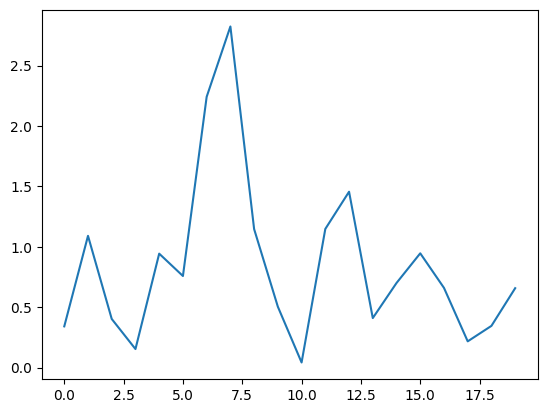

-----------------
0


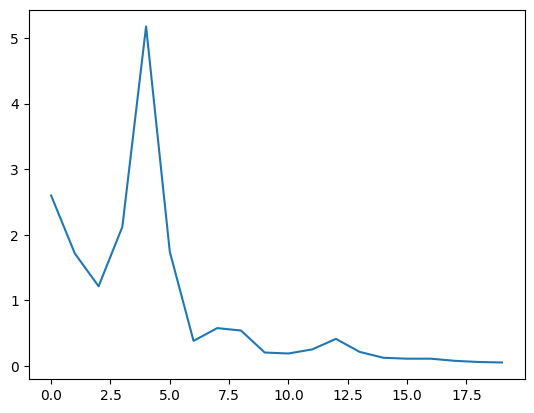

-----------------
1


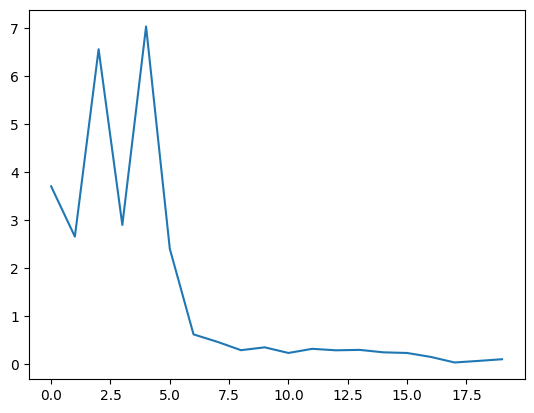

-----------------
0


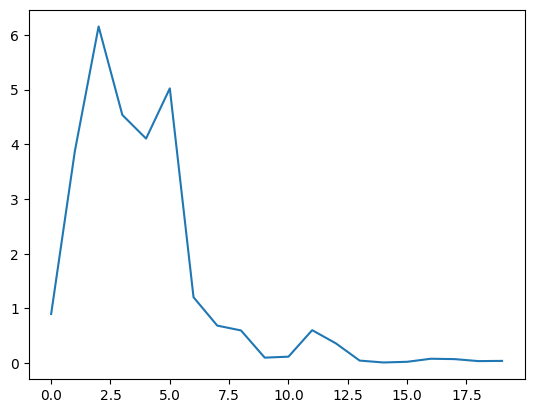

-----------------
1


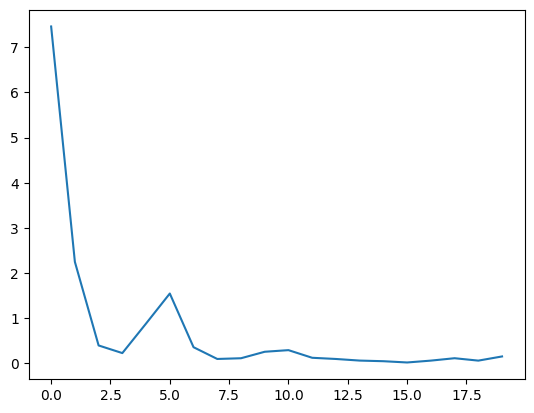

-----------------
1


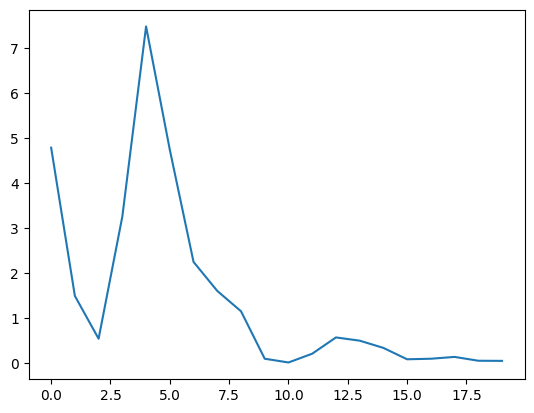

-----------------
0


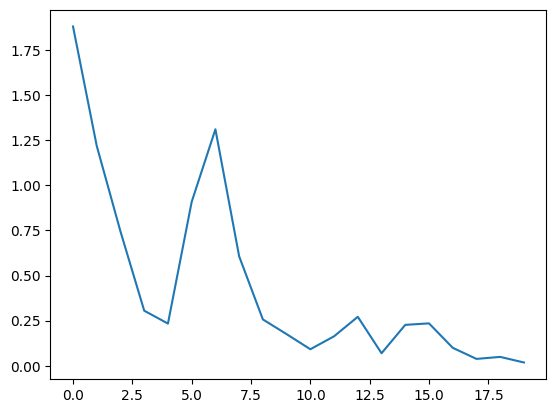

-----------------


true label 1
prediction 0


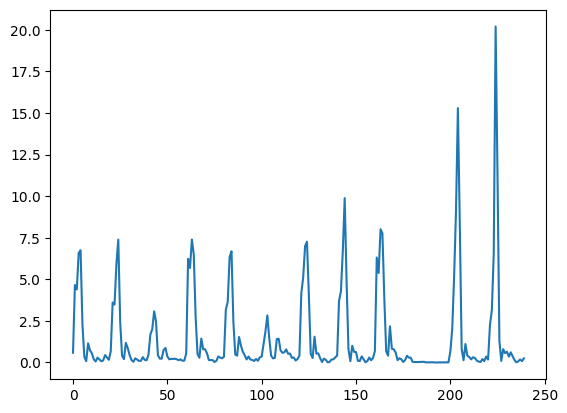

true label 0
prediction 1


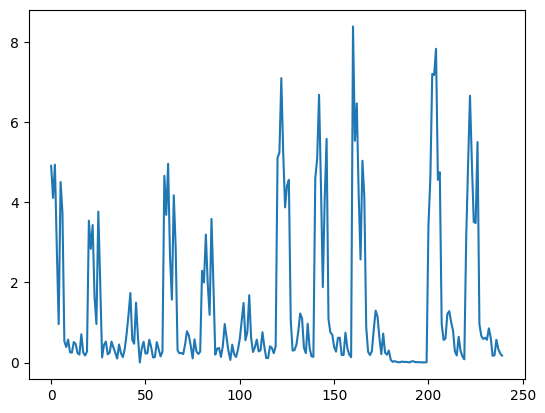

true label 1
prediction 0


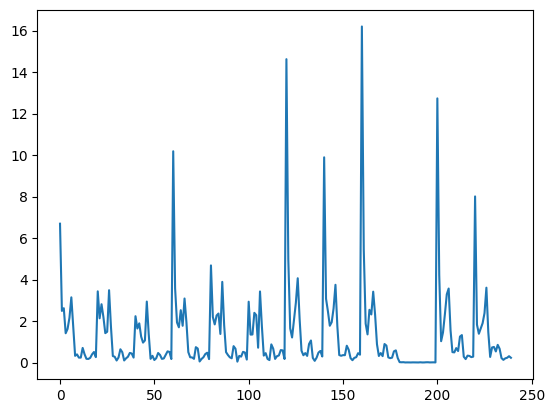

true label 0
prediction 0


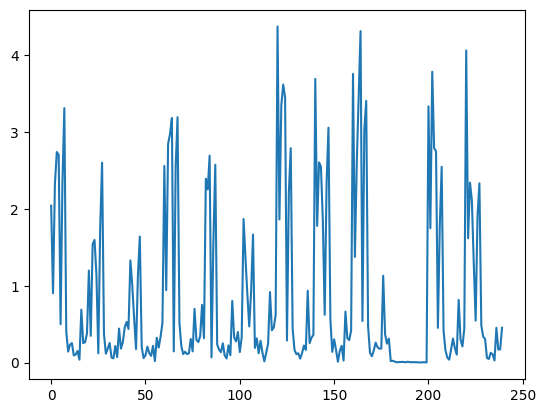

true label 1
prediction 0


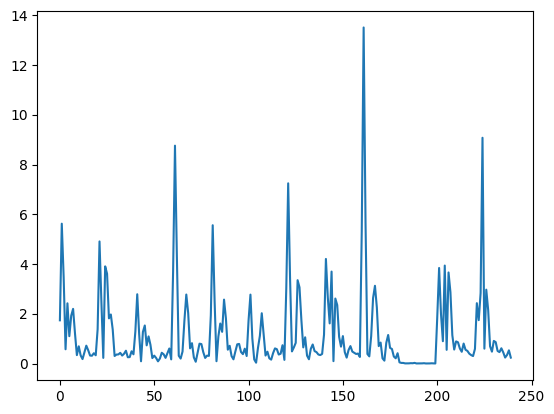

true label 0
prediction 0


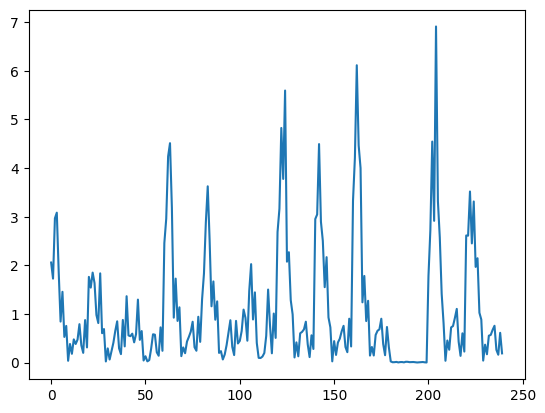

true label 0
prediction 0


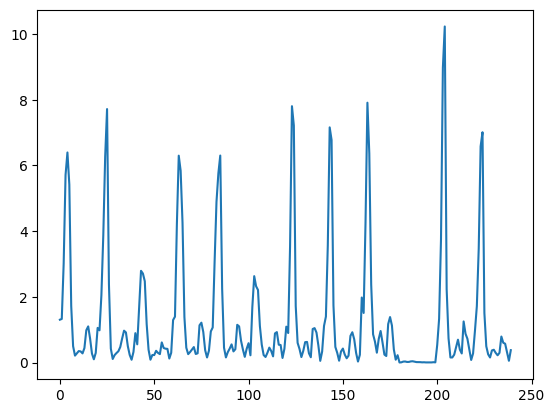

true label 1
prediction 0


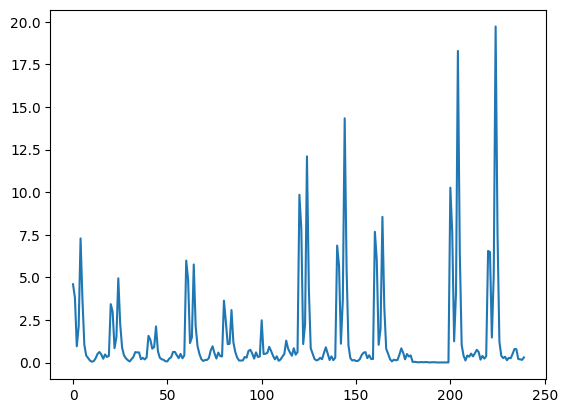

true label 1
prediction 0


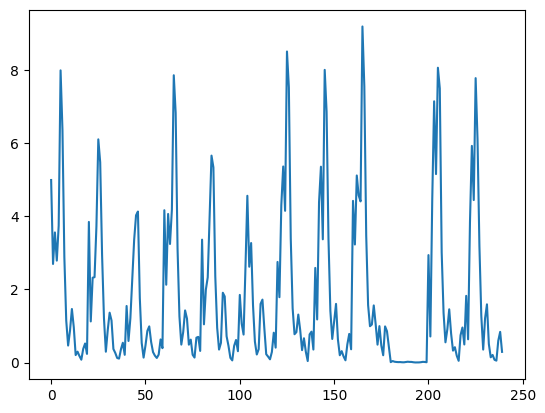

true label 0
prediction 0


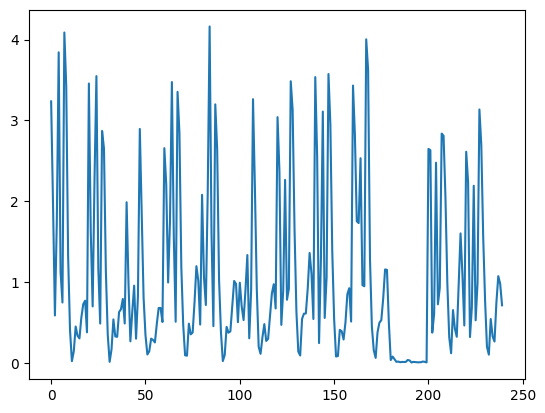

true label 0
prediction 0


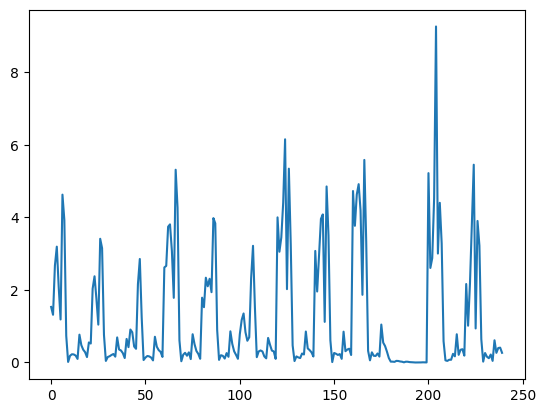

true label 1
prediction 0


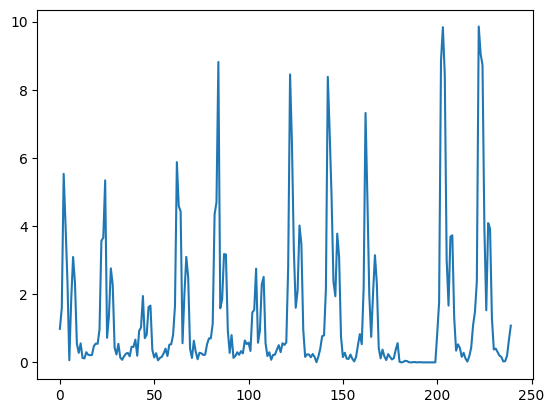

true label 1
prediction 0


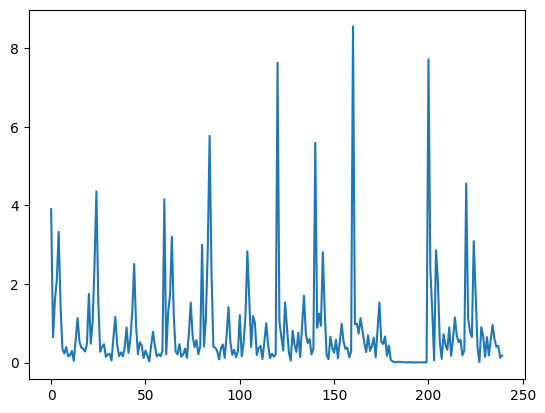

true label 0
prediction 0


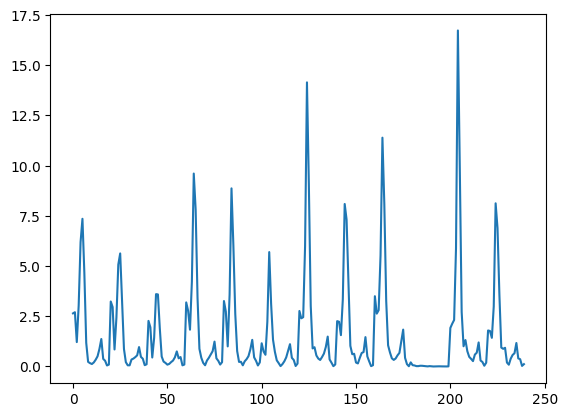

true label 1
prediction 0


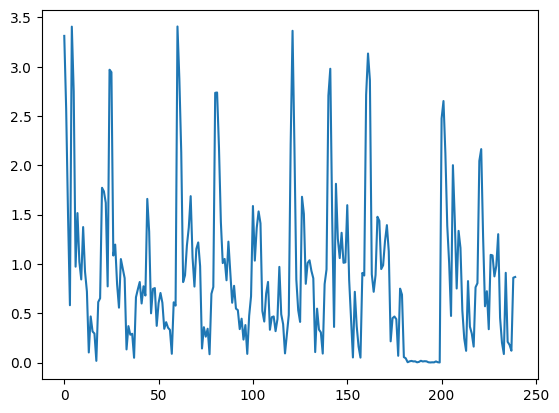

true label 1
prediction 1


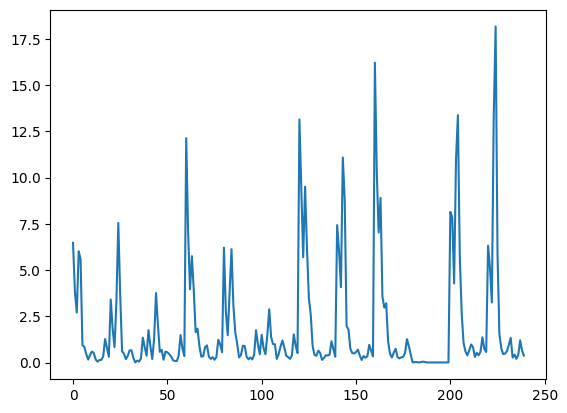

true label 0
prediction 0


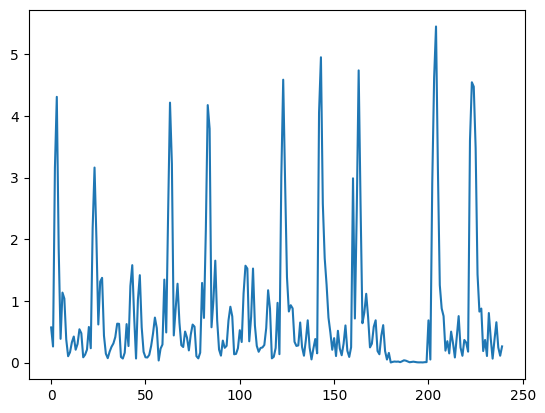

true label 0
prediction 0


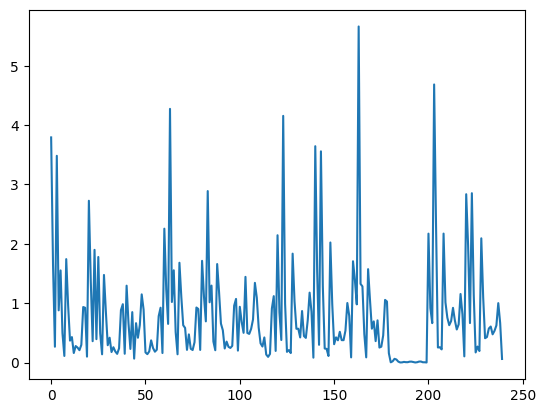

true label 1
prediction 0


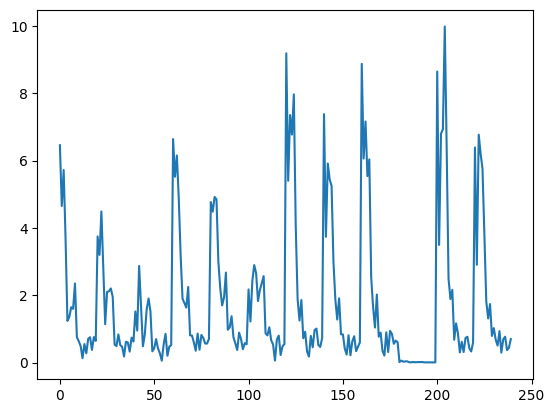

true label 0
prediction 0


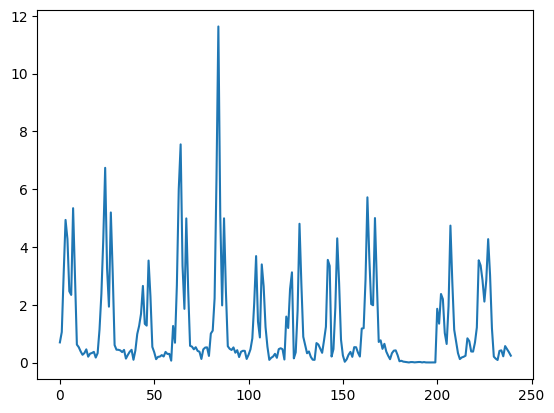

true label 1
prediction 0


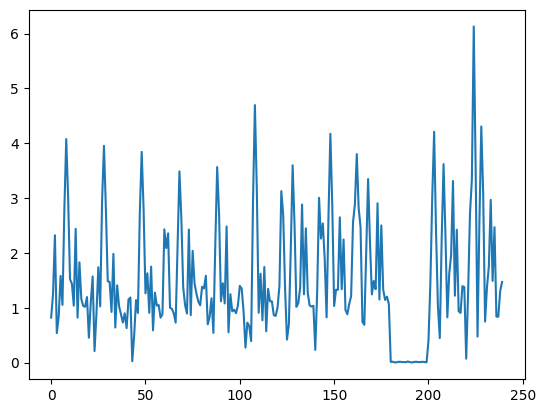

true label 0
prediction 0


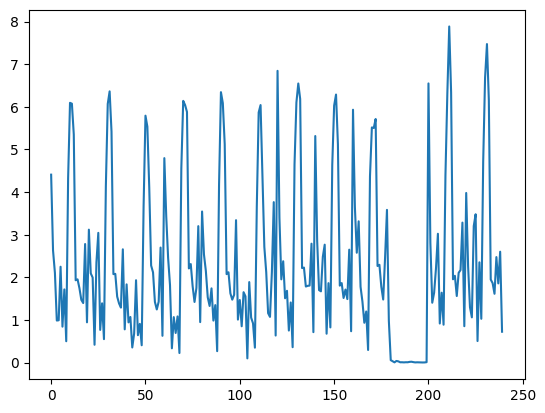

true label 1
prediction 0


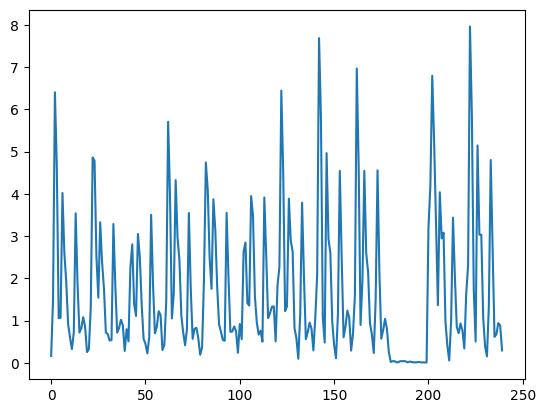

true label 1
prediction 0


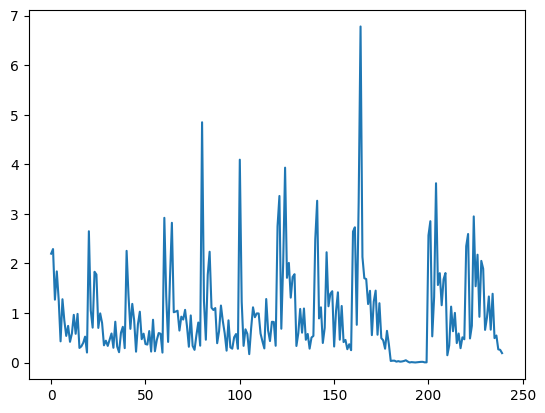

true label 0
prediction 0


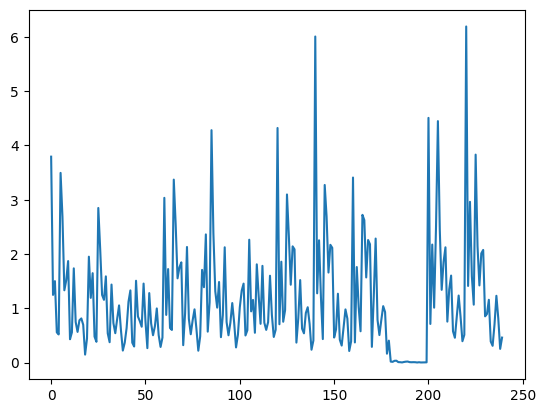

true label 0
prediction 0


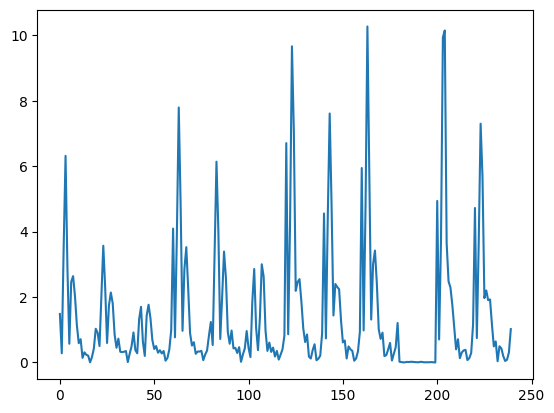

true label 1
prediction 0


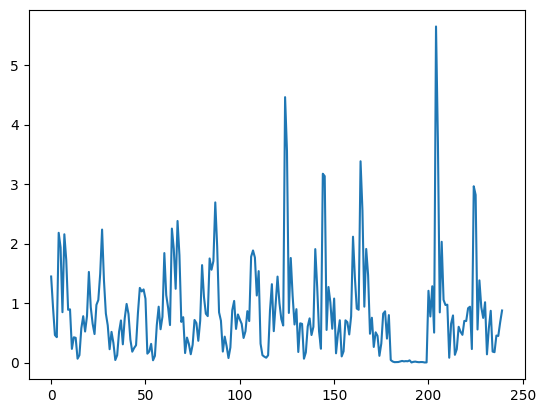

true label 0
prediction 0


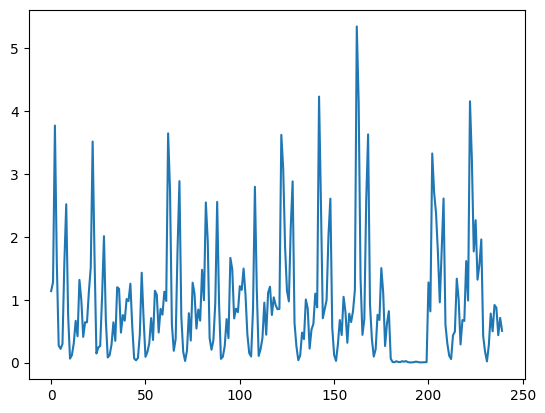

true label 0
prediction 0


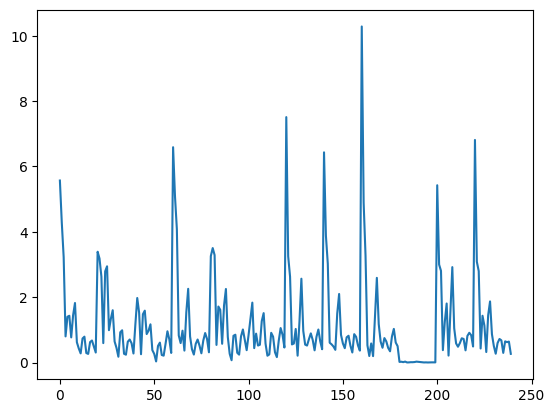

true label 1
prediction 1


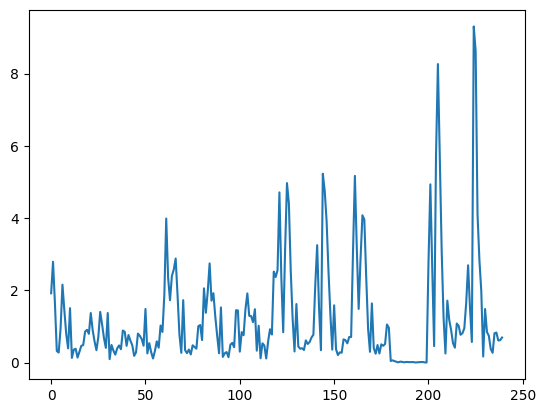

true label 1
prediction 0


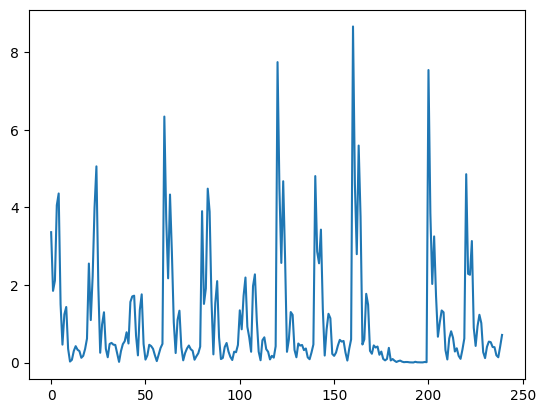

true label 0
prediction 0


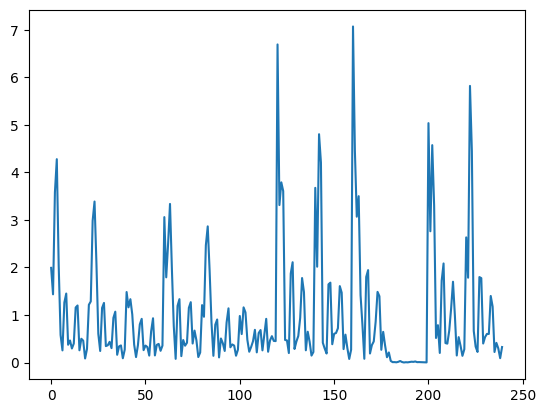

true label 1
prediction 0


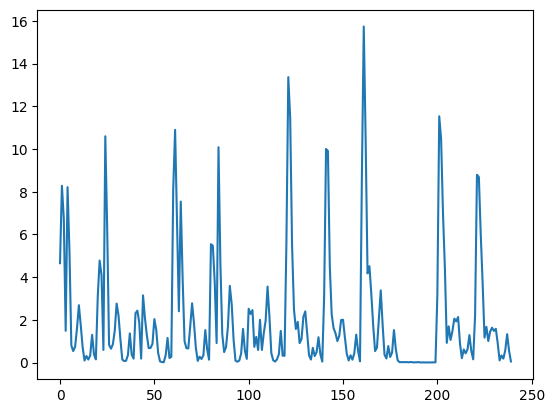

true label 0
prediction 0


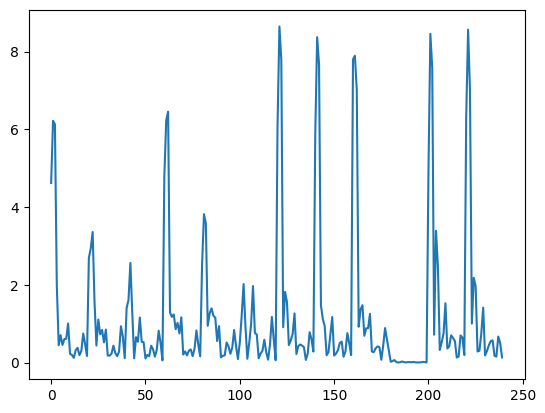

true label 1
prediction 0


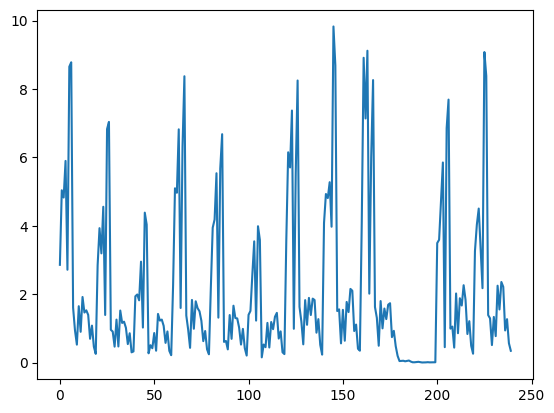

true label 0
prediction 0


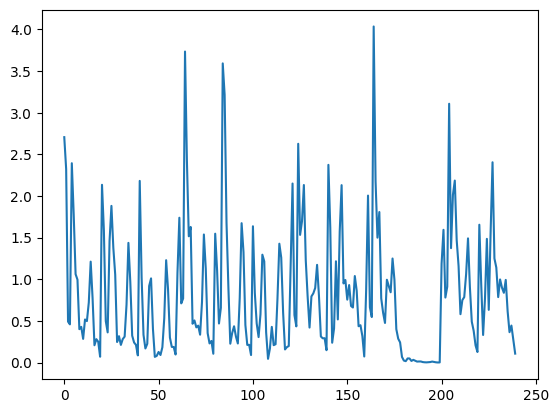

true label 1
prediction 0


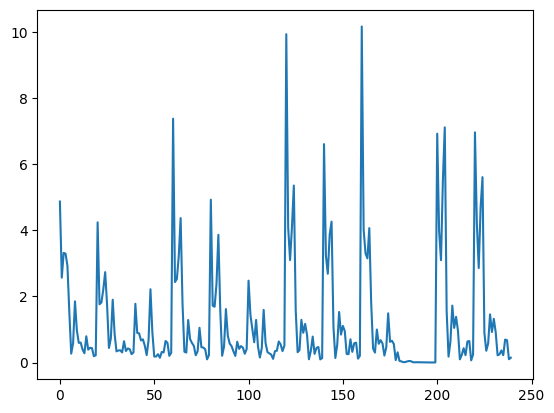

true label 0
prediction 0


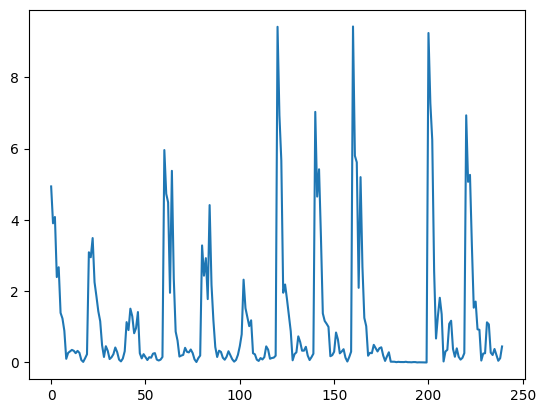

true label 1
prediction 0


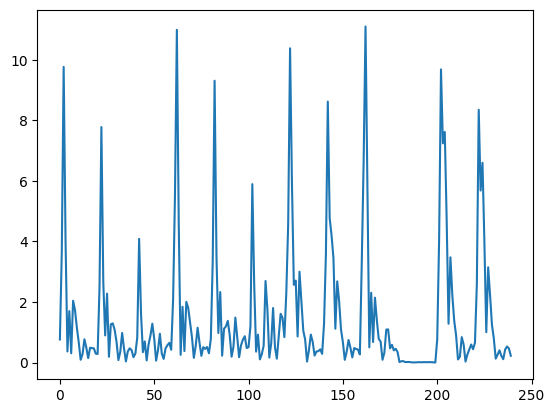

true label 0
prediction 0


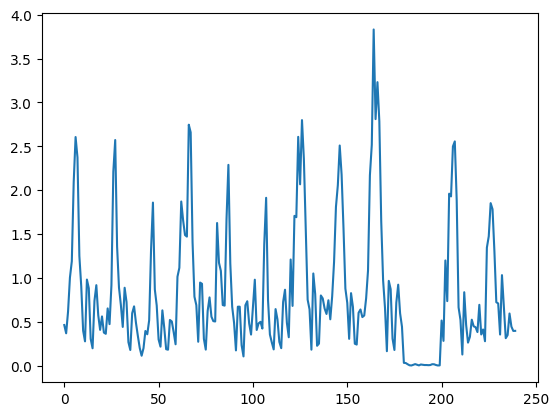

In [81]:
for i in range(len(y_test)):
    print("true label", y_test[i])
    print("prediction", preds[i])
    plt.plot(X_test[i,:])
    plt.show()